In [1]:
import xarray as xr
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import csv
from geopy.distance import geodesic
from datetime import timedelta
import pickle
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

In [2]:
tracking_start, tracking_end = "2012-01-01", "2012-12-31"

experiment_name = 'INALT60.L120-KRS0020' #'INALT20r.L120-KRS006'
data_resolution = '1d'

OW_thr_factor =-0.3
first_or_last_crossing = 'first'
minimum_duration = 5

In [3]:
if experiment_name.startswith("INALT60"):
    prefix = "2_"
    Npix_min, Npix_max = 720, 18000
    sigma = 15
    wx = 600
    ds_name = "inalt60"
    OW_end = 20120125
elif experiment_name.startswith("INALT20"):
    prefix = "1_"
    Npix_min, Npix_max = 80, 2000
    sigma = 5
    wx = 200
    ds_name = "inalt20r"
    OW_end = 20120219

In [4]:
#depth= 0  #corresponding to... 
#depth_index = 0 

mesh_mask = xr.open_dataset(f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/{prefix}{experiment_name}_mesh_mask.nc')
nav_lat = mesh_mask['nav_lat'].values  # shape (y, x)
nav_lon = mesh_mask['nav_lon'].values

indices = np.concatenate((range(0, 11, 10),range(18, 25, 6),range(29, 34, 4),range(36, 40, 3),range(41, 120, 2)))
depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in indices]
print(len(depth_information),depth_information)

48 [(0, 0), (21, 10), (54, 18), (91, 24), (132, 29), (173, 33), (210, 36), (253, 39), (286, 41), (323, 43), (365, 45), (412, 47), (465, 49), (525, 51), (592, 53), (668, 55), (753, 57), (848, 59), (952, 61), (1066, 63), (1189, 65), (1321, 67), (1461, 69), (1608, 71), (1762, 73), (1922, 75), (2086, 77), (2255, 79), (2428, 81), (2603, 83), (2782, 85), (2963, 87), (3146, 89), (3331, 91), (3518, 93), (3706, 95), (3896, 97), (4086, 99), (4279, 101), (4472, 103), (4666, 105), (4861, 107), (5057, 109), (5254, 111), (5452, 113), (5651, 115), (5850, 117), (6050, 119)]


In [5]:
ds_vort = xr.open_mfdataset(f'/gxfs_work/geomar/smomw523/processed_data/{experiment_name}/vorticity/{ds_name}-{data_resolution}-vorticity-*.nc').vorticity
ds_SSH = xr.open_mfdataset(f'/gxfs_work/geomar/smomw523/processed_data/{experiment_name}/SSH/{ds_name}-{data_resolution}-SSH-*.nc').sossheig
OW_exp = xr.open_dataset(f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-0/OW_20120101_{OW_end}_rolling-{wx}.nc').OW.isel(time=0)

In [ ]:
min_diameter, min_duration = 50, 10
filename = f'Tracks-crossed_{tracking_start.replace("-", "")}_{tracking_end.replace("-", "")}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.pickle'

datapath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-0/'
filepath = datapath + filename
tracks = np.load(datapath + filename, allow_pickle=True)

print(len(tracks))
for track_ix, track in tqdm(enumerate(tracks)):
    if track['scale'].max() < min_diameter or len(track['time']) < min_duration:
        continue
    times, lons, lats, eddy_type = track['time'], track['lon'], track['lat'], track['type']
    for i in range(len(times)):
        target_time = pd.to_datetime(times[i])
        eddies = np.load(datapath + f'Eddies_{target_time.strftime("%Y-%m-%d")}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.pickle', allow_pickle=True)

        max_SSH, max_vort = None, None
        for eddy_ix in range(len(eddies)):
            eddy = eddies[eddy_ix]
            if np.abs(eddy['lon'][0] - lons[i]) < 1e-3 and np.abs(eddy['lat'][0] - lats[i]) < 1e-3:
                ds_SSH_slice = ds_SSH.sel(time_counter=target_time)
                ds_vort_slice = ds_vort.sel(time_counter=target_time)

                eddy_lat = OW_exp['lat'].values[eddy['eddy_j']]
                eddy_lon = OW_exp['lon'].values[eddy['eddy_i']]
                eddy_coords = np.column_stack((eddy_lat, eddy_lon))
                flat_latlon = np.column_stack((nav_lat.ravel(), nav_lon.ravel()))
                tree = cKDTree(flat_latlon)
                _, indices = tree.query(eddy_coords)
                ys, xs = np.unravel_index(indices, nav_lat.shape)
                mask = np.zeros(ds_SSH_slice.shape, dtype=bool)
                mask[ys, xs] = True
                masked_SSH = ds_SSH_slice.where(mask) 
                masked_vort = ds_vort_slice.where(mask)
                if masked_SSH.count() == 0:
                    print(f"Warning: No mask for eddy. Skip. ({track_ix}, {eddy_ix})")
                    continue # should not be possible
                if eddy_type == 'cyclonic':
                    max_SSH = (masked_SSH.fillna(0).values - np.nanmean(ds_SSH_slice.values)).min()
                    max_vort = (masked_vort.fillna(0).values - np.nanmean(ds_vort_slice.values)).max()
                elif eddy_type == 'anticyclonic':
                    max_SSH = (masked_SSH.fillna(0).values - np.nanmean(ds_SSH_slice.values)).max()
                    max_vort = (masked_vort.fillna(0).values - np.nanmean(ds_vort_slice.values)).min()
                else:
                    print(f"Warning: No type for eddy. Skip. ({track_ix}, {eddy_ix})")
                    continue # should not be possible
                track['SSH'], track['vort'] = max_SSH, max_vort   
                break
            else:
                continue
            if max_SSH is None:
                print(f"Warning: No eddy found along track. Skip. ({track_ix})") # should not be possible
                continue
            elif max_vort is None:
                print(f"Warning: No eddy found along track. Skip. ({track_ix})") # should not be possible
                continue

with open(filepath, "wb") as f:
    pickle.dump(tracks, f)    

105it [1:10:32, 40.31s/it]


/tmp/ipykernel_3948362/2915027726.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


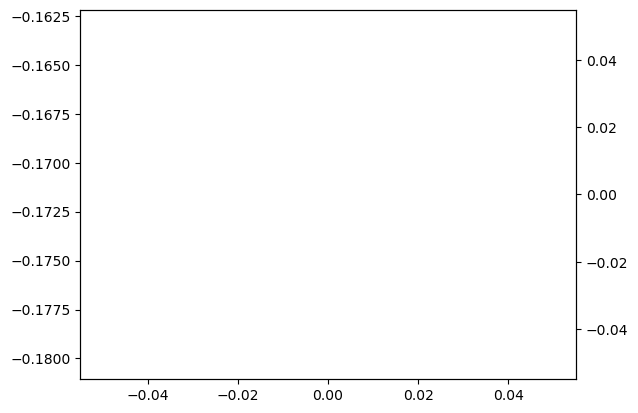

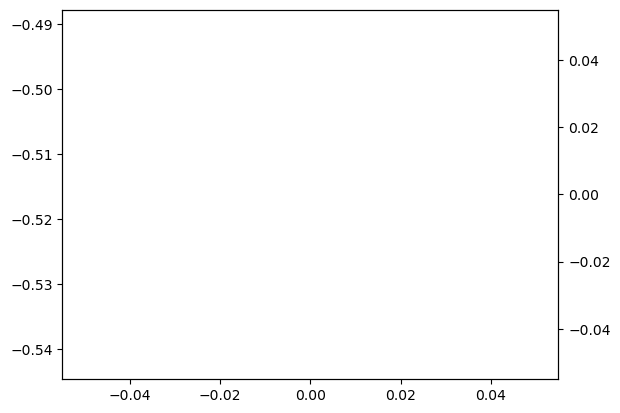

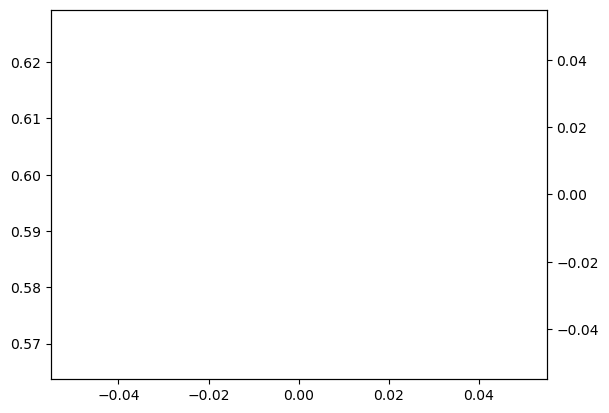

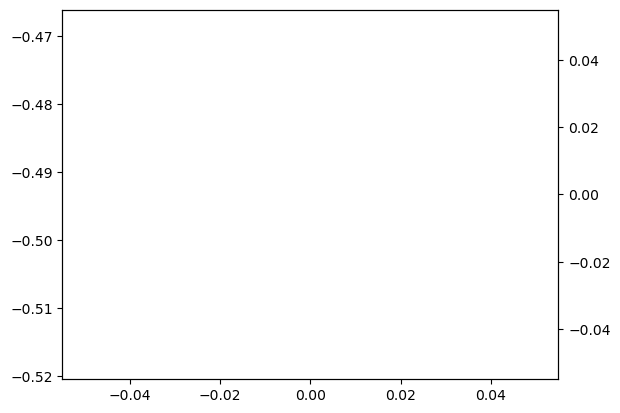

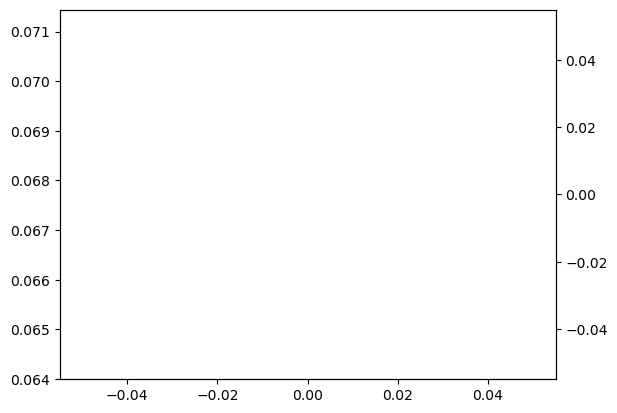

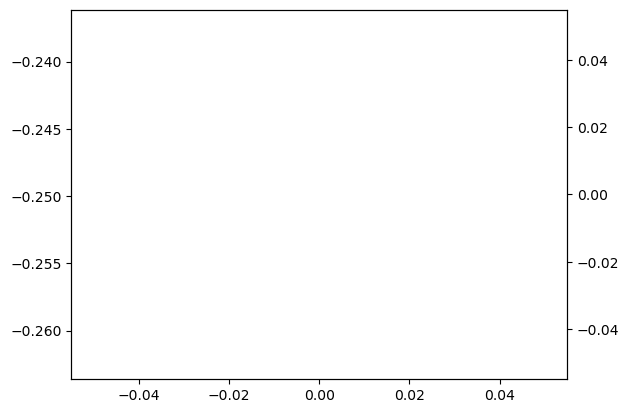

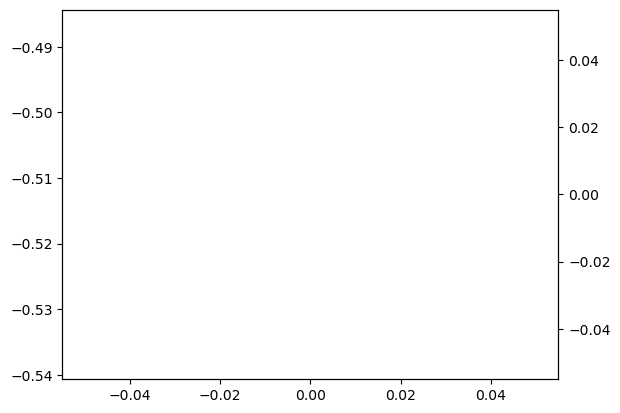

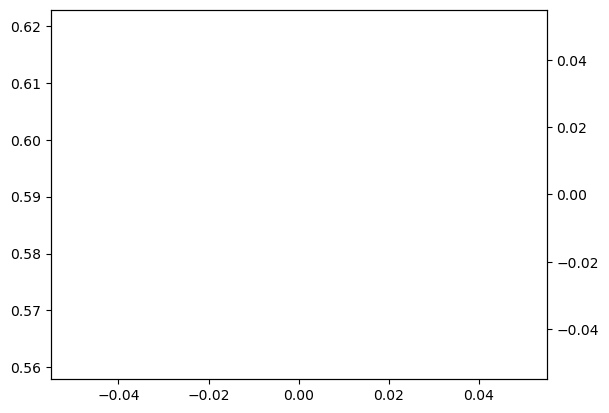

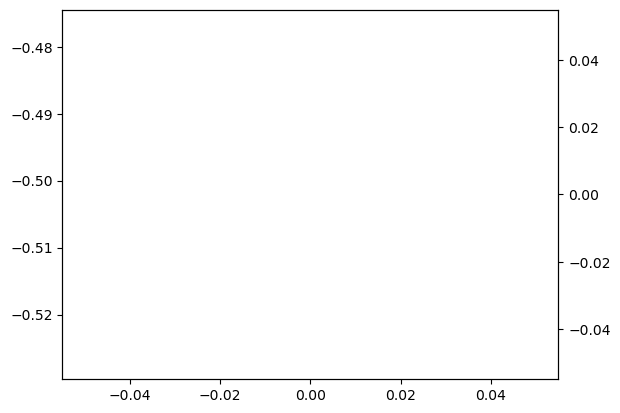

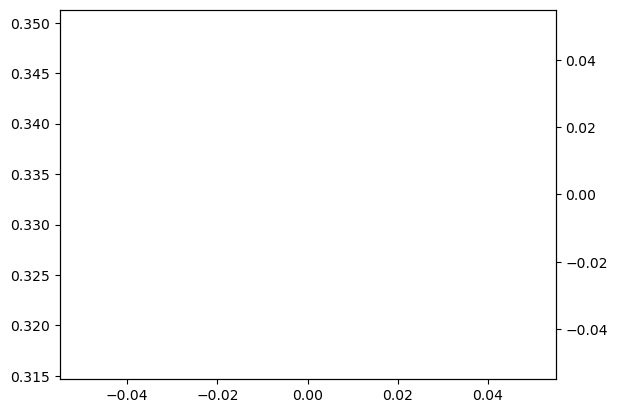

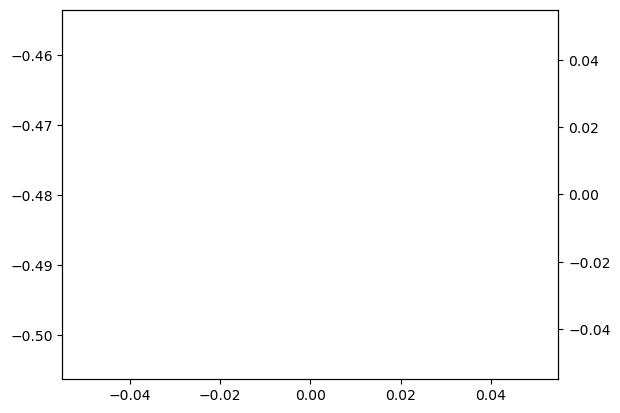

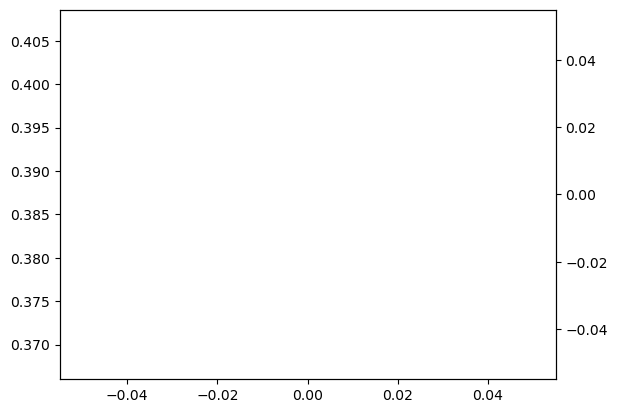

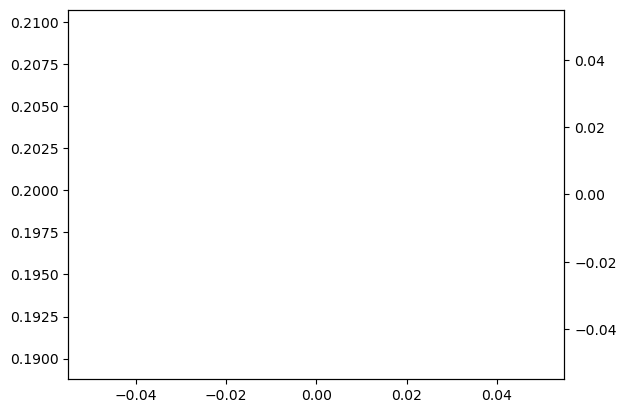

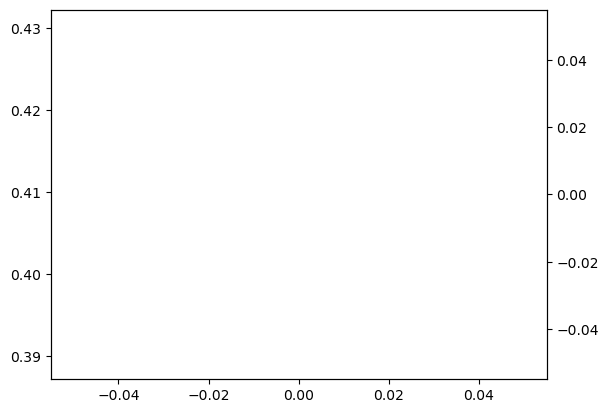

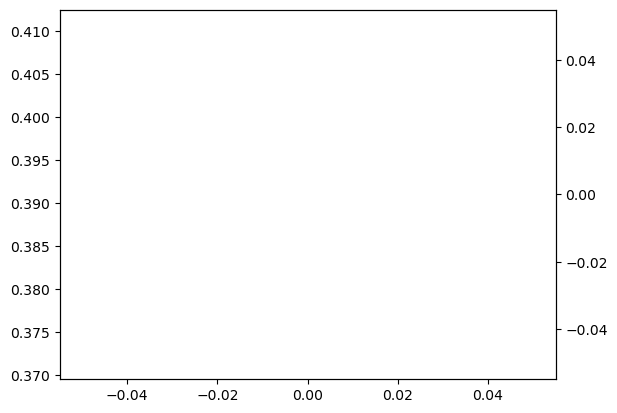

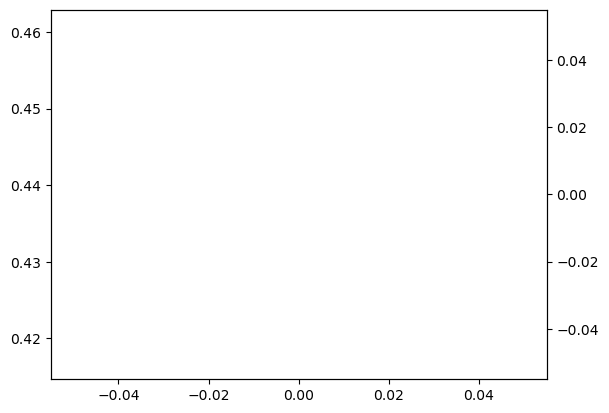

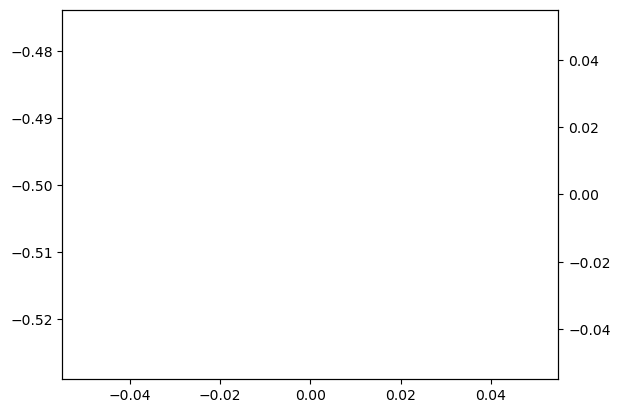

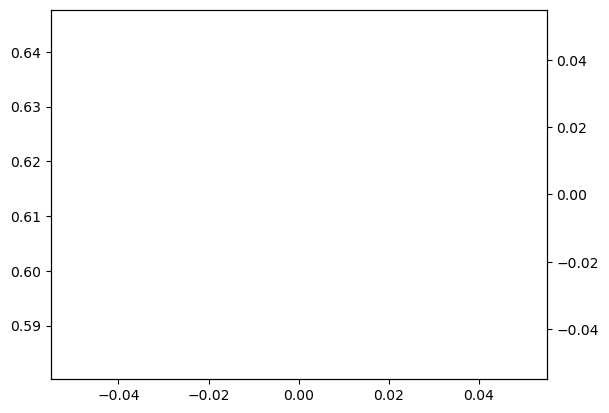

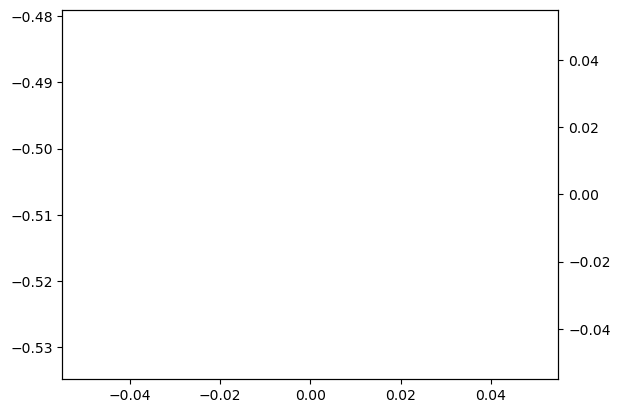

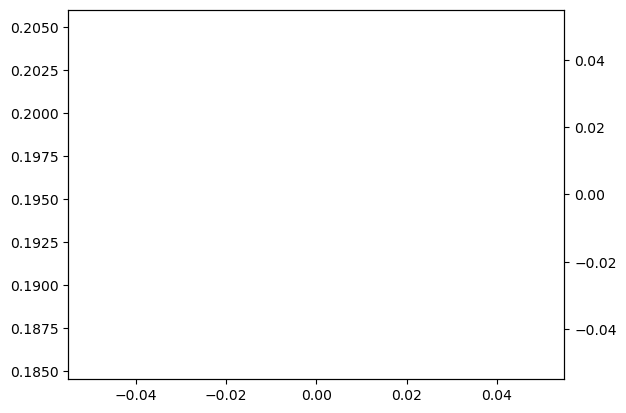

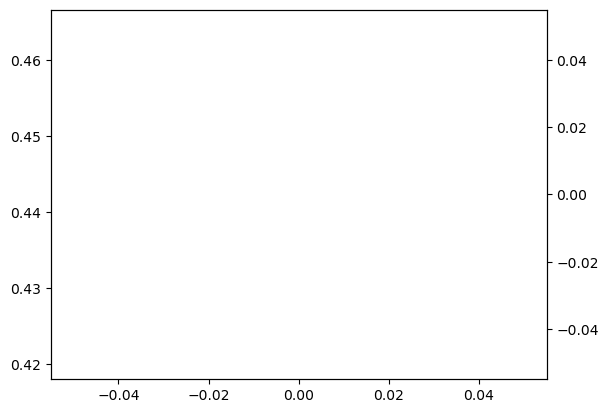

In [17]:
df = pd.read_csv(datapath + f'Good-hope-{first_or_last_crossing}-crossings_min-{minimum_duration}d_{tracking_start.replace("-", "")}_{tracking_end.replace("-", "")}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_rolling-{wx}.csv')
tracks = np.load(datapath + filename, allow_pickle=True)
for track_ix, track in enumerate(tracks):
    if df.loc[track_ix, 'section']!='Ansorge-GHS':
        continue # crossing wrong section
    if track['scale'].max() < min_diameter or len(track['time']) < min_duration:
        continue
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(track['SSH'], 'b', label='SSH')
    ax2.plot(track['vort'], 'r', label='Amp')      